torch.Size([64, 1, 28, 28]) torch.Size([64])


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


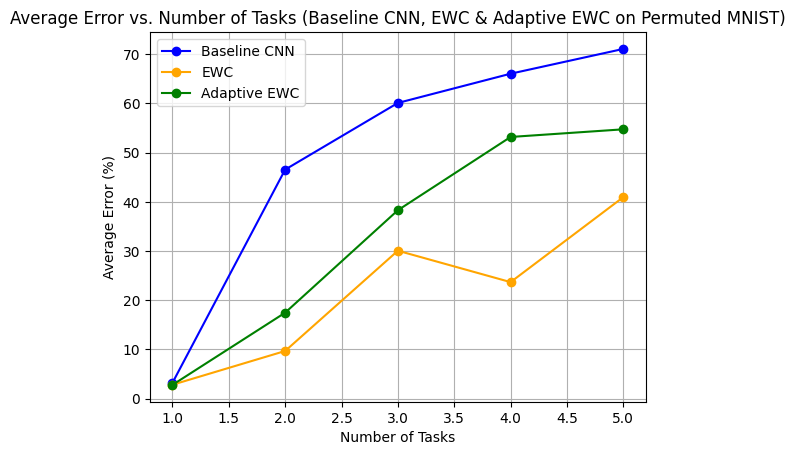

In [6]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def permute_dataset(dataset, permutation):
    permuted_data = dataset.data.view(-1, 28*28)[:, permutation]
    permuted_data = permuted_data.view(-1, 28, 28)
    dataset.data = permuted_data
    return dataset

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='.', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='.', train=False, download=True, transform=transform)

num_tasks = 5
input_size = 28 * 28
permutations = [np.random.permutation(input_size) for _ in range(num_tasks)]

permuted_datasets_train = []
permuted_datasets_test = []

for permutation in permutations:
    permuted_train = permute_dataset(datasets.MNIST(root='.', train=True, download=True, transform=transform), permutation)
    permuted_test = permute_dataset(datasets.MNIST(root='.', train=False, download=True, transform=transform), permutation)
    permuted_datasets_train.append(permuted_train)
    permuted_datasets_test.append(permuted_test)

first_task_train_loader = DataLoader(permuted_datasets_train[0], batch_size=64, shuffle=True)

for images, labels in first_task_train_loader:
    print(images.shape, labels.shape)
    break

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(model, train_loader, criterion, optimizer):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100.0 * (total - correct) / total

def flatness_penalty(model, dataloader, alpha=0.01, num_samples=10):
    original_loss = 0
    perturbed_losses = []

    criterion = nn.CrossEntropyLoss()
    model.eval()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            original_loss += loss.item()
    original_loss /= len(dataloader)

    # Perturb weights and compute perturbed losses
    for _ in range(num_samples):
        perturbed_loss = 0
        perturbed_model = BaselineCNN().to(device)
        perturbed_model.load_state_dict(model.state_dict())

        for param in perturbed_model.parameters():
            perturbation = torch.normal(0, alpha, size=param.shape).to(device)
            param.data += perturbation

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = perturbed_model(images)
                loss = criterion(outputs, labels)
                perturbed_loss += loss.item()
        perturbed_loss /= len(dataloader)
        perturbed_losses.append(perturbed_loss)

    # Average of all perturbed losses
    average_perturbed_loss = np.mean(perturbed_losses)

    # Flatness penalty
    return (average_perturbed_loss - original_loss) / len(list(model.parameters()))
# Elastic Weight Consolidation (EWC) class
class EWC(object):
    def __init__(self, model, dataloader):
        self.model = model
        self.dataloader = dataloader
        self.device = next(model.parameters()).device
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._precision_matrices = self._diag_fisher()
        self._means = {n: p.clone().detach() for n, p in self.params.items()}

    def _diag_fisher(self):
        precision_matrices = {n: torch.zeros_like(p, device=self.device) for n, p in self.params.items()}
        self.model.eval()
        for input, target in self.dataloader:
            input, target = input.to(self.device), target.to(self.device)
            self.model.zero_grad()
            output = self.model(input)
            loss = nn.functional.nll_loss(nn.functional.log_softmax(output, dim=1), target)
            loss.backward()
            for n, p in self.params.items():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataloader)
        return precision_matrices

    def penalty(self, model):
        loss = 0
        for n, p in model.named_parameters():
            if p.requires_grad:
                _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
                loss += lambda_flat*flatness_penalty(model, self.dataloader)
                loss += _loss.sum()
        return loss

# Adaptive EWC Optimizer class
class AdaptiveEWCOptimizer:
    def __init__(self, ewc, lambda_min=1000, lambda_max=5000, alpha=1.1, beta=0.9):
        self.ewc = ewc
        self.lambda_min = lambda_min
        self.lambda_max = lambda_max
        self.alpha = alpha
        self.beta = beta
        self.ewc_lambda = lambda_min

    def adjust_lambda(self, model):
        grad_magnitudes = []
        for n, p in model.named_parameters():
            if p.grad is not None and p.requires_grad:
                grad_magnitudes.append(torch.norm(p.grad.data).item())
        avg_grad = np.mean(grad_magnitudes)

        if avg_grad > 1:
            self.ewc_lambda = min(self.ewc_lambda * self.alpha, self.lambda_max)
        else:
            self.ewc_lambda = max(self.ewc_lambda * self.beta, self.lambda_min)

    def penalty(self, model):
        return self.ewc_lambda * self.ewc.penalty(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_errors = []

for task in range(num_tasks):
    train_loader = DataLoader(permuted_datasets_train[task], batch_size=64, shuffle=True)
    test_loader = DataLoader(permuted_datasets_test[task], batch_size=64, shuffle=False)

    # Re-initialize the model and optimizer for each task
    model = BaselineCNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Train for a fixed number of epochs
    num_epochs = 50
    for epoch in range(num_epochs):
        train(model, train_loader, nn.CrossEntropyLoss(), optimizer)

    # Evaluate the model on all tasks seen so far
    total_error = 0
    for eval_task in range(task + 1):
        test_loader = DataLoader(permuted_datasets_test[eval_task], batch_size=64, shuffle=False)
        total_error += evaluate(model, test_loader, nn.CrossEntropyLoss())

    baseline_errors.append(total_error / (task + 1))

plt.plot(range(1, num_tasks + 1), baseline_errors, marker='o', label='Baseline CNN', color='blue')

lambda_ewc = 50  # Adjust this value as needed
lambda_flat = 0.01

ewc_errors = []

model = BaselineCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

ewc = None
for task in range(num_tasks):
    train_loader = DataLoader(permuted_datasets_train[task], batch_size=64, shuffle=True)
    test_loader = DataLoader(permuted_datasets_test[task], batch_size=64, shuffle=False)

    if task > 0:
        ewc = EWC(model, train_loader)

    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            if ewc is not None:
                loss += lambda_ewc * ewc.penalty(model)
            loss.backward()
            optimizer.step()

    total_error = 0
    for eval_task in range(task + 1):
        test_loader = DataLoader(permuted_datasets_test[eval_task], batch_size=64, shuffle=False)
        total_error += evaluate(model, test_loader, criterion)

    ewc_errors.append(total_error / (task + 1))

plt.plot(range(1, num_tasks + 1), ewc_errors, marker='o', label='EWC', color='orange')

adaptive_ewc_errors = []

model = BaselineCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

ewc = None
adaptive_ewc_optimizer = None
for task in range(num_tasks):
    train_loader = DataLoader(permuted_datasets_train[task], batch_size=64, shuffle=True)
    test_loader = DataLoader(permuted_datasets_test[task], batch_size=64, shuffle=False)

    if task > 0:
        ewc = EWC(model, train_loader)
        adaptive_ewc_optimizer = AdaptiveEWCOptimizer(ewc, lambda_min=0, lambda_max=10, alpha=1.1, beta=0.9)

    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            if adaptive_ewc_optimizer is not None:
                loss += adaptive_ewc_optimizer.penalty(model)
                adaptive_ewc_optimizer.adjust_lambda(model)
            loss.backward()
            optimizer.step()

    total_error = 0
    for eval_task in range(task + 1):
        test_loader = DataLoader(permuted_datasets_test[eval_task], batch_size=64, shuffle=False)
        total_error += evaluate(model, test_loader, criterion)

    adaptive_ewc_errors.append(total_error / (task + 1))

plt.plot(range(1, num_tasks + 1), adaptive_ewc_errors, marker='o', label='Adaptive EWC', color='green')

plt.xlabel('Number of Tasks')
plt.ylabel('Average Error (%)')
plt.title('Average Error vs. Number of Tasks (Baseline CNN, EWC & Adaptive EWC on Permuted MNIST)')
plt.legend()
plt.grid(True)
plt.show()
